# 라이브러리 준비

In [1]:
import nltk

nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\korea\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\korea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\korea\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\korea\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

# 토큰화 및 품사 태깅

In [2]:
from nltk import word_tokenize, pos_tag, ne_chunk

text = 'James is working at Disney in London'
text = pos_tag(word_tokenize(text))
text

[('James', 'NNP'),
 ('is', 'VBZ'),
 ('working', 'VBG'),
 ('at', 'IN'),
 ('Disney', 'NNP'),
 ('in', 'IN'),
 ('London', 'NNP')]

# 개체명 인식

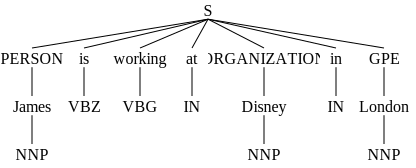

In [3]:
text = ne_chunk(text)
text

# 개체명 인식 - LSTM
## 라이브러리 준비

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import urllib.request

## 데이터 준비

In [5]:
tagged_sentences = []
sentence = []

with urllib.request.urlopen('https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt') as f:
    for line in f:
        line = line.decode('utf-8')
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == '\n':
            if len(sentence) > 0:
                tagged_sentences.append(sentence)
                sentence = []
            continue
        splits = line.strip().split(' ')
        word = splits[0].lower()
        sentence.append([word, splits[-1]])

print(len(tagged_sentences))
print(tagged_sentences[0])

14041
[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


## 데이터 전처리
- 단어와 개체명 태그를 분리해서 데이터를 구성

In [6]:
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences:
    sentence, tag_info = zip(*tagged_sentence)
    sentences.append(list(sentence))
    ner_tags.append(list(tag_info))

- 정제 및 빈도 수가 높은 상위 단어들만 추출하기 위해 토큰화 작업

In [7]:
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [8]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1

print(vocab_size)
print(tag_size)

4000
10


- 데이터를 학습에 활용하기 위해 데이터를 배열로 변환
- 해당 작업은 토큰화 툴의 texts_to_sequences()를 통해 수행

In [9]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

- 학습에 투입할 때는 동일한 길이를 가져야 하므로, 지정해둔 최대 길이에 맞춰 모든 데이터를 동일한 길이로 맞춰줌
- 일반적으로 길이를 맞출 때는 모자란 길이만큼 0을 추가

In [10]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

- 훈련, 실험 데이터 분리 및 원 핫 인코딩을 시행

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2)

y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

- 최종적으로 생성된 데이터셋의 크기는 다음과 같음

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11232, 70)
(11232, 70, 10)
(2809, 70)
(2809, 70, 10)


# 모델 구축 및 학습
- 모델 구축에는 keras를 이용
- 해당 작업에 필요한 함수들을 추가로 import

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [14]:
from keras.callbacks import TensorBoard
import datetime

log_dir = '../logs/model' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

## 모델의 구성

1. 입력을 실수 벡터로 임베딩
2. 양방향 LSTM 구성
3. Dense layer를 통한 각 태그에 속할 확률 예측

`TimeDistributed`는 상위 layer의 출력이 step에 따라 여러 개로 출력되어 이를 적절하게 분배해주는 역할

In [15]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 128)           512000    
                                                                 
 bidirectional (Bidirection  (None, 70, 512)           788480    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 70, 10)            5130      
 ributed)                                                        
                                                                 
Total params: 1305610 (4.98 MB)
Trainable params: 1305610 (4.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(.001),
              metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_test, y_test), callbacks=[tensorboard])

Epoch 1/3
88/88 [==============================] - 156s 2s/step - loss: 0.9029 - accuracy: 0.8238 - val_loss: 0.6144 - val_accuracy: 0.8342
Epoch 2/3
88/88 [==============================] - 149s 2s/step - loss: 0.4713 - accuracy: 0.8568 - val_loss: 0.3750 - val_accuracy: 0.8885
Epoch 3/3
88/88 [==============================] - 154s 2s/step - loss: 0.3040 - accuracy: 0.9097 - val_loss: 0.2591 - val_accuracy: 0.9228


In [17]:
model.evaluate(X_test, y_test)

88/88 [==============================] - 10s 115ms/step - loss: 0.2596 - accuracy: 0.9228


[0.2595982849597931, 0.9228242039680481]

## 학습한 모델을 통한 예측
* 예측을 확인하기 위해서 인덱스를 단어로 변환해줄 사전이 필요
* 사전은 토큰화 툴의 사전을 이용

In [18]:
idx2word = src_tokenizer.index_word
idx2ner = tar_tokenizer.index_word
idx2ner[0] = 'PAD'

* 예측 시각화

In [19]:
i = 10
y_predicted = model.predict(np.array([X_test[i]]))
y_predicted = np.argmax(y_predicted, axis=-1)
true = np.argmax(y_test[i], -1)

print(f"{'단어':15}|{'실제값':5}|  '예측값'")
print('-'*50)

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0:
        print('{:17} : {:7} {}'.format(idx2word[w], idx2ner[t].upper(), idx2ner[pred].upper()))

1/1 [==============================] - 4s 4s/step
단어             |실제값  |  '예측값'
--------------------------------------------------
cleveland         : B-ORG   B-ORG
76                : O       O
53                : O       O
OOV               : O       O
-                 : O       O
